In [1]:
import findspark
findspark.init()
from pyspark import SparkContext
from pyspark.streaming import StreamingContext
from pyspark.sql import SparkSession, Row
from pyspark.sql.window import Window
from pyspark.sql.functions import col, row_number, regexp_replace, sum, when, count, round as sparkrnd, max as sparkmax, min as sparkmin, year, avg as sparkavg, stddev as sparkstd,explode,split, col, count, round, avg
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import regexp_replace
import numpy as np


In [2]:
#Start spark session
spark = SparkSession.builder.getOrCreate()

24/06/24 23:16:11 WARN Utils: Your hostname, dsbda-vm resolves to a loopback address: 127.0.1.1; using 192.168.64.2 instead (on interface enp0s1)
24/06/24 23:16:11 WARN Utils: Set SPARK_LOCAL_IP if you need to bind to another address
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/06/24 23:16:11 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
24/06/24 23:16:12 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [3]:
file_path = "/home/ubuntu/DATASET/calendar.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

#Remove from price the characters: "$ ," -> the character "." is not removed to allow a better text analysis to vader,nltk... 
df_cleaned = df.withColumn("cleaned_price", regexp_replace(col("price"), r"[\$,]", "").cast("double"))
df_cleaned = df_cleaned.filter(col("cleaned_price").isNotNull())

#Analysis1: stats on price per listing_id, availability analysis per listing id, minmaxavg price, availability percentage
print("Average prices for listing id")
df_general = df_cleaned.groupBy("listing_id").agg(
    sparkavg("cleaned_price").alias("avg_price"),
    sparkmax("cleaned_price").alias("max_price"),
    sparkmin("cleaned_price").alias("min_price"),
    sparkstd("cleaned_price").alias("price_stddev"),
    count("available").alias("availability_count"),
    (sum(when(col("available") == "t", 1).otherwise(0)) / count("*")).alias("percentage_available")
)
#This command is auto-limited -> it prints at most the first 20 rows
#df_general.show(20)
df_general.show()

#Analysis2: Media dei prezzi per data
print("Media prezzi per data")
df_avg_price_by_date = df_cleaned.groupBy("listing_id", "available").agg({"cleaned_price": "avg"}).withColumnRenamed("avg(cleaned_price)", "avg_price")
df_avg_price_by_date.show()

df_date = df_cleaned.groupBy("date").agg({"cleaned_price": "avg"}).withColumnRenamed("avg(cleaned_price)", "avg_price")
df_avg_price_by_date.show()


pdf_general = df_general.toPandas()
pdf_avg_price_by_date = df_avg_price_by_date.toPandas()


Average prices for listing id


+----------+------------------+---------+---------+------------------+------------------+--------------------+
|listing_id|         avg_price|max_price|min_price|      price_stddev|availability_count|percentage_available|
+----------+------------------+---------+---------+------------------+------------------+--------------------+
|     62015|             131.5|    175.0|    130.0| 8.215838362577491|                30|                 1.0|
|     69042|154.57142857142858|    175.0|    116.0|27.281600288210992|                 7|                 1.0|
|    984134|             114.0|    114.0|    114.0|               0.0|               179|                 1.0|
|   1298851|             249.0|    249.0|    249.0|              null|                 1|                 1.0|
|   1380262|             179.0|    179.0|    179.0|               0.0|               261|                 1.0|
|   1435255| 239.6868131868132|    299.0|    129.0| 81.13737452393433|               364|                 1.0|
|

+----------+---------+------------------+
|listing_id|available|         avg_price|
+----------+---------+------------------+
|    635019|        t|120.28169014084507|
|    699991|        t|              95.0|
|   1088859|        t|             100.0|
|   1260229|        t|155.75555555555556|
|   1523635|        t| 98.28048780487805|
|   1801900|        t|108.80177514792899|
|   3307814|        t|             200.0|
|   4601431|        t| 95.42372881355932|
|   4761059|        t|133.02197802197801|
|   7893478|        t|331.46067415730334|
|   7969191|        t|440.38461538461536|
|   8197219|        t| 105.7919254658385|
|    289071|        t| 88.88636363636364|
|   1805233|        t|             179.0|
|   2030833|        t|             106.0|
|   2459307|        t|             150.0|
|   3761686|        t| 94.96296296296296|
|   3705061|        t|             175.0|
|   4476077|        t|           168.125|
|   4259933|        t|             198.5|
+----------+---------+------------

+----------+---------+------------------+
|listing_id|available|         avg_price|
+----------+---------+------------------+
|    635019|        t|120.28169014084507|
|    699991|        t|              95.0|
|   1088859|        t|             100.0|
|   1260229|        t|155.75555555555556|
|   1523635|        t| 98.28048780487805|
|   1801900|        t|108.80177514792899|
|   3307814|        t|             200.0|
|   4601431|        t| 95.42372881355932|
|   4761059|        t|133.02197802197801|
|   7893478|        t|331.46067415730334|
|   7969191|        t|440.38461538461536|
|   8197219|        t| 105.7919254658385|
|    289071|        t| 88.88636363636364|
|   1805233|        t|             179.0|
|   2030833|        t|             106.0|
|   2459307|        t|             150.0|
|   3761686|        t| 94.96296296296296|
|   3705061|        t|             175.0|
|   4476077|        t|           168.125|
|   4259933|        t|             198.5|
+----------+---------+------------

root
 |-- id: string (nullable = true)
 |-- name: string (nullable = true)
 |-- host_id: string (nullable = true)
 |-- host_name: string (nullable = true)
 |-- neighbourhood_group: string (nullable = true)
 |-- neighbourhood: string (nullable = true)
 |-- latitude: string (nullable = true)
 |-- longitude: string (nullable = true)
 |-- room_type: string (nullable = true)
 |-- price: string (nullable = true)
 |-- minimum_nights: integer (nullable = true)
 |-- number_of_reviews: string (nullable = true)
 |-- last_review: string (nullable = true)
 |-- reviews_per_month: string (nullable = true)
 |-- calculated_host_listings_count: double (nullable = true)
 |-- availability_365: integer (nullable = true)

+----------------+-----------------+--------------------+---------+-----------+
|latitude_rounded|longitude_rounded|       neighbourhood|avg_price|avg_reviews|
+----------------+-----------------+--------------------+---------+-----------+
|      52.3585317|        4.8975109|        Centru

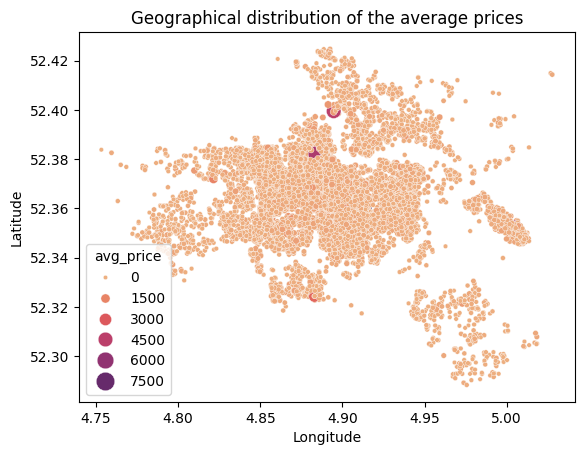

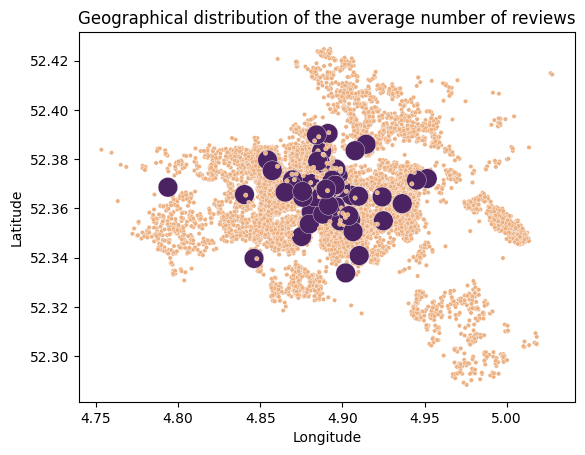

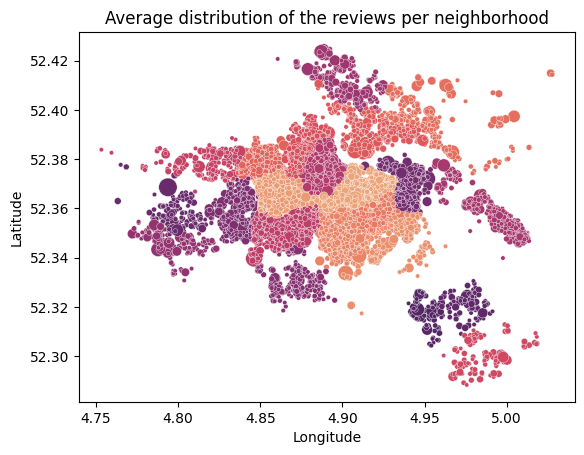

In [4]:
file_path = "/home/ubuntu/DATASET/listings.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)
df.printSchema()

#Remove from price the characters: "$ ,"
df_cleaned = df.withColumn("cleaned_price", regexp_replace(col("price"), r"[\$,]", "").cast("double"))
#df_cleaned.show()
#df_cleaned.show(20)

# remove nulls from 'cleaned_price' e 'number_of_reviews'
df_cleaned = df_cleaned.filter(
    col("cleaned_price").isNotNull() &
    col("number_of_reviews").isNotNull() &
    col("neighbourhood").isin(["Bijlmer-Centrum", "Bijlmer-Oost", "Bos en Lommer", "Buitenveldert - Zuidas", "Centrum-Oost", "Centrum-West", "De Aker - Nieuw Sloten", "De Baarsjes - Oud-West", "De Pijp - Rivierenbuurt", "Gaasperdam - Driemond", "Geuzenveld - Slotermeer", "IJburg - Zeeburgereiland", 
                                "Noord-Oost", "Noord-West", "Oostelijk Havengebied - Indische Buurt", "Osdorp", "Oud-Noord" , "Oud-Oost", "Slotervaart", "Watergraafsmeer", "Westerpark","Zuid"])
)

df_cleaned = df_cleaned.withColumn("latitude_rounded", sparkrnd(col("latitude"), 7)).withColumn("longitude_rounded", sparkrnd(col("longitude"), 7)).drop("longitude").drop("latitude")

#Avg price and number of reviews according to the neighborhood and rounded geographical coordinates
df_general_location = df_cleaned.groupBy("latitude_rounded", "longitude_rounded", "neighbourhood").agg({"cleaned_price": "avg", "number_of_reviews": "avg"}).withColumnRenamed("avg(cleaned_price)", "avg_price").withColumnRenamed("avg(number_of_reviews)", "avg_reviews")
df_general_location.show()
#df_general_location.show(20)

#Find the neighborhood with the heighest number of listings
df_listings_count_by_neighbourhood = df_cleaned.groupBy("neighbourhood").agg({"id":"count"})
df_listings_count_by_neighbourhood.show()

#Find the host witht the highest number of listings
df_host_with_most_listings = df_cleaned.groupBy("host_id", "host_name").agg(sum("calculated_host_listings_count").alias("total_listings")).orderBy(col("total_listings").desc())
df_host_with_most_listings.show()

#To visualize the data I will use pandas dataframe
threshold = 200
pdf_general_location = df_general_location.toPandas()
pdf_general_location['size_category'] = pdf_general_location['avg_reviews'].apply(lambda x: 200 if x > 350 else 10)
pdf_non_relevant_reviews = pdf_general_location[pdf_general_location['avg_reviews'] < threshold]
pdf_relevant_reviews = pdf_general_location[pdf_general_location['avg_reviews'] > threshold]
df_avg_reviews_by_neighbourhood = df_cleaned.groupBy("latitude_rounded", "longitude_rounded", "neighbourhood").agg({"number_of_reviews":"avg"}).withColumnRenamed("avg(number_of_reviews)", "avg_reviews")
df_avg_reviews_by_neighbourhood.show()
pdf_avg_review_neighbourhood = df_avg_reviews_by_neighbourhood.toPandas()

# Visualizzare la distribuzione geografica dei prezzi
plt.figure()
sns.scatterplot(data=pdf_general_location, x="longitude_rounded", y="latitude_rounded", size="avg_price", hue="avg_price", legend=True, sizes=(10, 200), palette = "flare")
plt.title("Geographical distribution of the average prices")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Visualizzare la distribuzione geografica delle recensioni
plt.figure()
sns.scatterplot(data=pdf_non_relevant_reviews, x="longitude_rounded", y="latitude_rounded", size="size_category", hue="size_category", legend=False, sizes=(10, 200), palette="flare")
sns.scatterplot(data=pdf_relevant_reviews, x="longitude_rounded", y="latitude_rounded", size="size_category", hue="size_category", legend=False, sizes=(10, 200), palette="flare")
plt.title("Geographical distribution of the average number of reviews")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

plt.figure()
sns.scatterplot(data=pdf_avg_review_neighbourhood, x="longitude_rounded", y="latitude_rounded", size="avg_reviews", hue="neighbourhood", legend=False, sizes=(10, 200), palette = "flare")
plt.title("Average distribution of the reviews per neighborhood")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

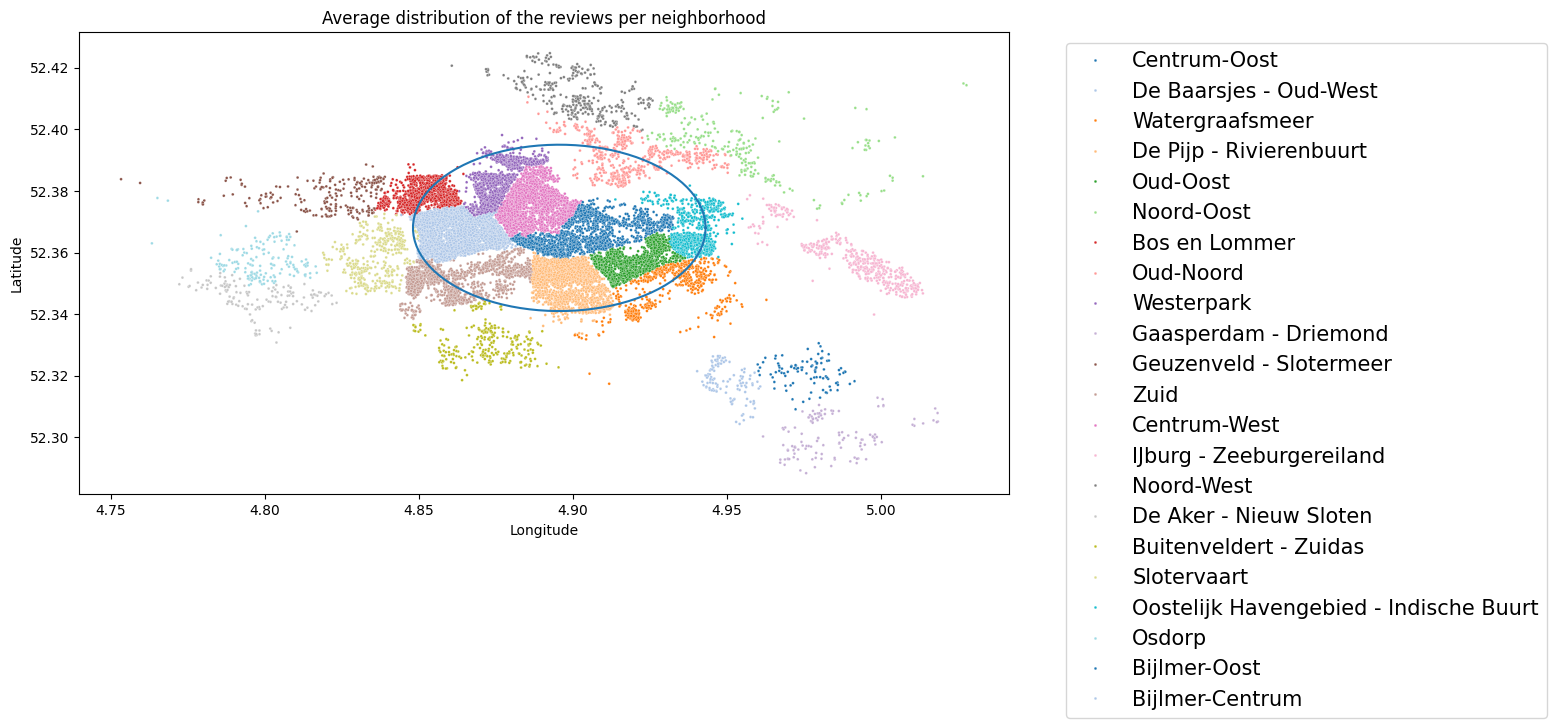

In [5]:
center_long = 4.8955
center_lati = 52.368
#radius = 0.055 # unlock for circular neighborhood (intorno circolare)
#theta = np.linspace(0, 2 * np.pi, 100)
#x = center_long + radius * np.cos(theta)
#y = center_lati + radius * np.sin(theta)

semi_major_axis = 0.0475
semi_minor_axis = 0.0270
theta = np.linspace(0, 2 * np.pi, 100)

# Define ellipse points
x = center_long + semi_major_axis * np.cos(theta)
y = center_lati + semi_minor_axis * np.sin(theta)


plt.figure(figsize=(12, 8))
sns.scatterplot(data=pdf_avg_review_neighbourhood, x="longitude_rounded", y="latitude_rounded", s=4, hue="neighbourhood", legend=True, sizes=(10, 200), palette="tab20")
plt.title("Average distribution of the reviews per neighborhood")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.plot(x, y)
plt.gca().set_aspect('equal', adjustable='box')
#push the legend out of the img
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left',  prop={'size': 15})

plt.show()

In [6]:
print("Max price")
max_price = df_cleaned.agg(sparkmax("cleaned_price").alias("max_cleaned_price")).collect()[0]["max_cleaned_price"]
print(max_price)

Max price
8500.0


root
 |-- listing_id: string (nullable = true)
 |-- id: string (nullable = true)
 |-- date: string (nullable = true)
 |-- reviewer_id: string (nullable = true)
 |-- reviewer_name: string (nullable = true)
 |-- comments: string (nullable = true)



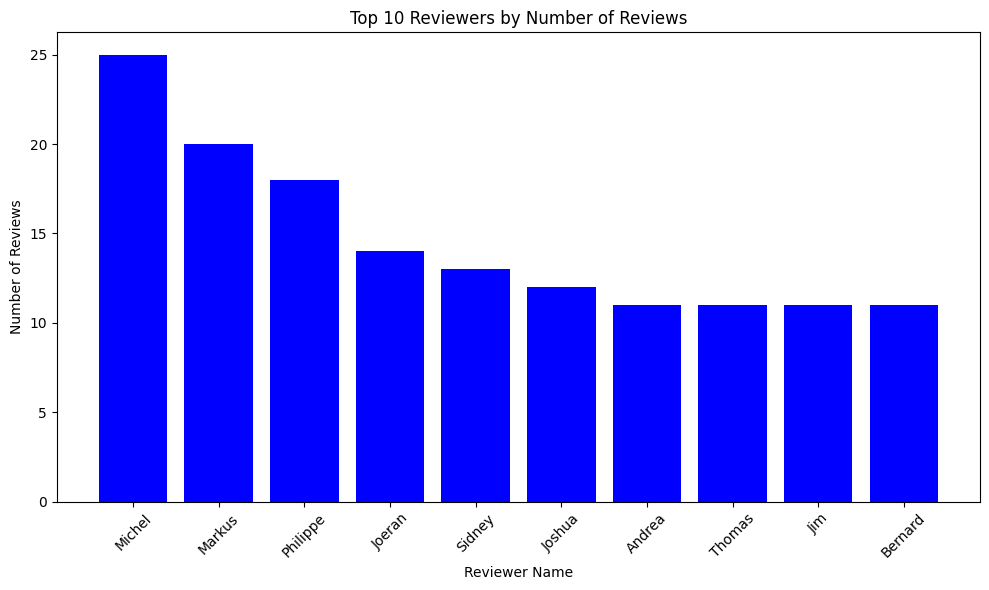

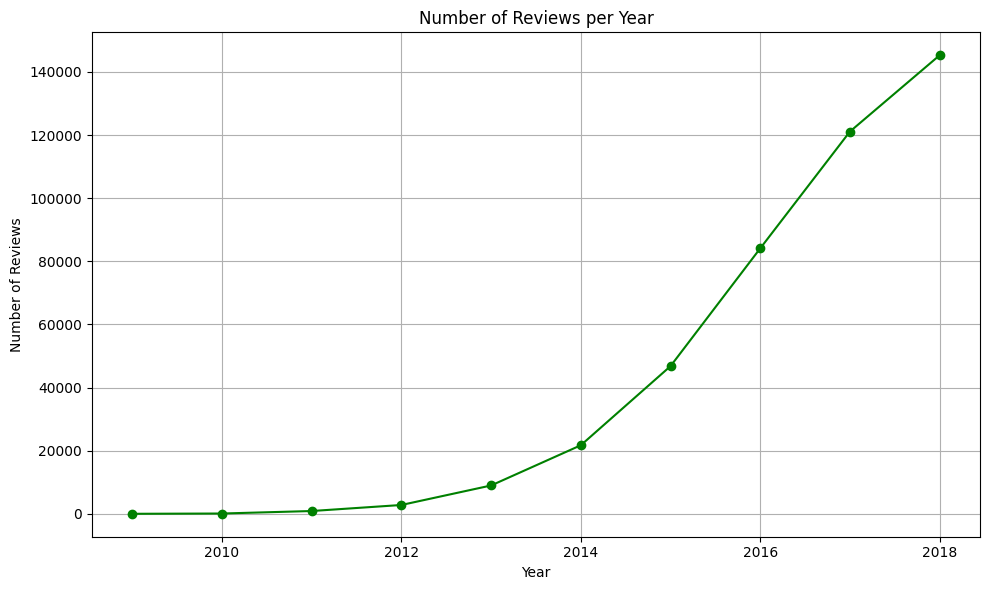

In [7]:
file_path = "/home/ubuntu/DATASET/reviews_details.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

df.printSchema()

#Find the reviewer with the highest number of reviews
df_reviews_per_reviewer = df.groupBy("reviewer_id", "reviewer_name").agg(count("id").alias("num_reviews")).orderBy(col("num_reviews").desc())
df_reviews_per_reviewer = df_reviews_per_reviewer.filter(col("reviewer_id").isNotNull() & col("reviewer_name").isNotNull())
top_reviewers = df_reviews_per_reviewer.limit(10).toPandas()

#Number of review per year
df = df.withColumn("year", year(col("date")))
df_reviews_per_year = df.groupBy("year").agg(count("id").alias("num_reviews")).orderBy(col("year"))
reviews_per_year = df_reviews_per_year.toPandas()

# Plots
plt.figure(figsize=(10, 6))
plt.bar(top_reviewers['reviewer_name'], top_reviewers['num_reviews'], color='blue')
plt.xlabel('Reviewer Name')
plt.ylabel('Number of Reviews')
plt.title('Top 10 Reviewers by Number of Reviews')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(reviews_per_year['year'], reviews_per_year['num_reviews'], marker='o', linestyle='-', color='green')
plt.xlabel('Year')
plt.ylabel('Number of Reviews')
plt.title('Number of Reviews per Year')
plt.grid(True)
plt.tight_layout()
plt.show()

Analisi 1: percentage of the most common properties type
+-----------+-----+------------------+
|word       |count|percentage        |
+-----------+-----+------------------+
|Apartment  |10696|83.1209201119055  |
|House      |1064 |8.26857320484924  |
|Townhouse  |448  |3.481504507304942 |
|Loft       |240  |1.8650917003419334|
|Boat       |215  |1.6708113148896488|
|Condominium|205  |1.5930991607087348|
+-----------+-----+------------------+



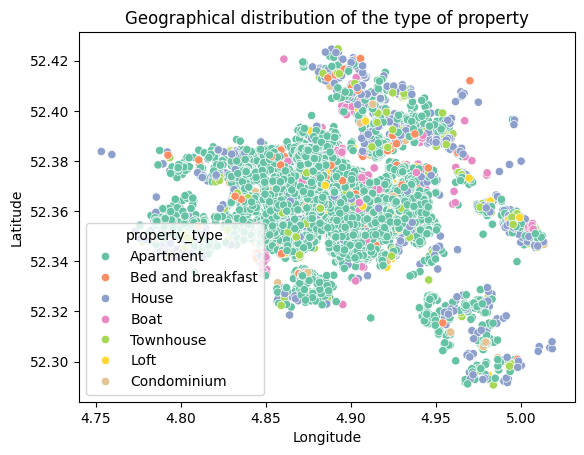

Number of Super Host: 1608 out of 18631
Geographical distribution of super hosts:


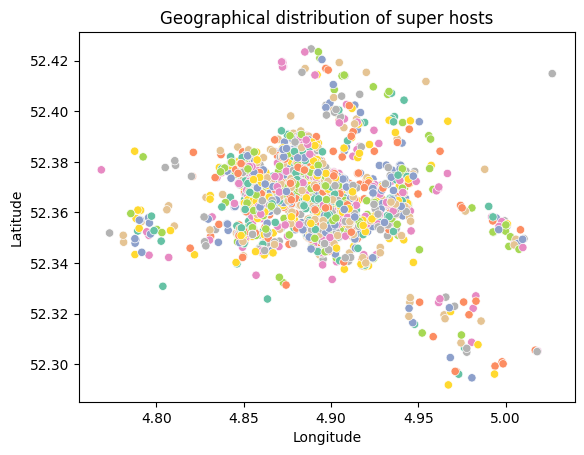

Host distribution per neighborhood


+--------------------------------------+----------+----------+
|neighbourhood_cleansed                |host_count|percentage|
+--------------------------------------+----------+----------+
|De Baarsjes - Oud-West                |2376      |17.48     |
|De Pijp - Rivierenbuurt               |1620      |11.92     |
|Centrum-West                          |1520      |11.18     |
|Centrum-Oost                          |1184      |8.71      |
|Zuid                                  |1000      |7.36      |
|Westerpark                            |967       |7.11      |
|Oud-Oost                              |877       |6.45      |
|Bos en Lommer                         |809       |5.95      |
|Oostelijk Havengebied - Indische Buurt|649       |4.77      |
|Watergraafsmeer                       |418       |3.08      |
|Oud-Noord                             |386       |2.84      |
|IJburg - Zeeburgereiland              |315       |2.32      |
|Slotervaart                           |261       |1.92

+--------------------------------------+------------------+
|neighbourhood_cleansed                |average_price     |
+--------------------------------------+------------------+
|Buitenveldert - Zuidas                |1050.0            |
|Noord-Oost                            |211.66666666666666|
|De Baarsjes - Oud-West                |170.06521739130434|
|Oud-Noord                             |162.6             |
|Centrum-West                          |151.32142857142858|
|De Aker - Nieuw Sloten                |150.0             |
|Centrum-Oost                          |146.55            |
|Oud-Oost                              |119.46153846153847|
|De Pijp - Rivierenbuurt               |110.73076923076923|
|Oostelijk Havengebied - Indische Buurt|110.0             |
|Slotervaart                           |107.5             |
|Zuid                                  |100.25            |
|Watergraafsmeer                       |96.5              |
|Westerpark                            |

In [8]:
#Listing details table analysis

file_path = "/home/ubuntu/DATASET/listings_details.csv"
df = spark.read.csv(file_path, header=True, inferSchema=True)

df_cleaned = df.withColumn("latitude_rounded", round(col("latitude"), 7)) \
               .withColumn("longitude_rounded", round(col("longitude"), 7))

#Analysis 1: percentage of the most common properties type
keywords = ["Apartment", "House", "Townhouse", "Bed and breakfast", "Loft", "Boat", "Condominium"]
words_df = df_cleaned.select(explode(split(col("property_type"), "\\s+")).alias("word"))
filtered_df_p = words_df.filter(col("word").isin(keywords))
word_counts_df = filtered_df_p.groupBy("word").count().orderBy(col("count").desc())
total_count = word_counts_df.select(sum("count").alias("total_count")).collect()[0]["total_count"]
word_percentage_df = word_counts_df.withColumn("percentage", (col("count") / total_count) * 100)

print("Analysis 1: percentage of the most common properties type")
word_percentage_df.show(truncate=False)

# Analisys 2: Geographical distribution of the type of property
filtered_df_geo = df_cleaned.filter(col("property_type").isin(keywords))
result_df = filtered_df_geo.groupBy("property_type", "latitude_rounded", "longitude_rounded").count().toPandas()

plt.figure()
sns.scatterplot(data=result_df, x="longitude_rounded", y="latitude_rounded",
                hue="property_type", palette="Set2", legend="full", sizes=(10, 200))
plt.title("Geographical distribution of the type of property")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
plt.show()

# Analysis 3: Number of Super Host
number_of_super_hosts = df.filter(col("host_is_superhost") == 't').select("host_id").distinct().count()
total_hosts = df.select("host_id").distinct().count()
print(f"Number of Super Host: {number_of_super_hosts} out of {total_hosts}")

# Analysis 4: Geographical distribution of super hosts
df_super_hosts = df_cleaned.filter(col("host_is_superhost") == 't') \
                           .filter(col("latitude_rounded").isNotNull()) \
                           .filter(col("longitude_rounded").isNotNull()) \
                           .filter(col("latitude_rounded") > 52) \
                           .filter(col("longitude_rounded") > 4) \
                           .select("host_id", "latitude_rounded", "longitude_rounded").toPandas()

plt.figure()
sns.scatterplot(data=df_super_hosts, x="longitude_rounded", y="latitude_rounded",
                hue="host_id", palette="Set2", legend=False, sizes=(10, 200))
plt.title("Geographical distribution of super hosts")
plt.xlabel("Longitude")
plt.ylabel("Latitude")
print(f"Geographical distribution of super hosts:")
plt.show()

# Analysis 5: Host distribution per neighborhood
neighborhood_patterns = [
    "%Bijlmer-Centrum%", "%Bijlmer-Oost%", "%Bos en Lommer%", "%Buitenveldert%,%Zuidas%", "%Centrum-Oost%",
    "%Centrum-West%", "%De Aker%", "%Nieuw Sloten%", "%De Baarsjes - Oud-West%", "%De Pijp%", "%Rivierenbuurt%",
    "%Gaasperdam - Driemond%", "%Geuzenveld - Slotermeer%", "%IJburg - Zeeburgereiland%", "%Noord-Oost%",
    "%Noord-West%", "%Oostelijk Havengebied - Indische Buurt%", "%Osdorp%", "%Oud-Noord%", "%Oud-Oost%",
    "%Slotervaart%", "%Watergraafsmeer%", "%Westerpark%", "%Zuid%"
]

filtered_neighborhood_df = df_cleaned.filter(col("neighbourhood_cleansed").rlike("|".join([pattern.replace("%", ".*") for pattern in neighborhood_patterns])))
hosts_per_neighborhood = filtered_neighborhood_df.groupBy("neighbourhood_cleansed").agg(count("host_id").alias("host_count"))
total_hosts_neighborhood = filtered_neighborhood_df.select(count("host_id").alias("total_host_count")).collect()[0]["total_host_count"]
hosts_percentage_neighborhood_df = hosts_per_neighborhood.withColumn("percentage", round((col("host_count") / total_hosts_neighborhood) * 100, 2))
sorted_hosts_percentage_neighborhood_df = hosts_percentage_neighborhood_df.orderBy(col("percentage").desc())

print("Host distribution per neighborhood")
sorted_hosts_percentage_neighborhood_df.show(truncate=False)

# Analysis 6: Average price per neighborhood
filtered_price_df = filtered_neighborhood_df.withColumn("price", regexp_replace(col("price"), "[$,]", "").cast("float"))
avg_price_per_neighborhood_df = filtered_price_df.groupBy("neighbourhood_cleansed").agg(avg("price").alias("average_price")).orderBy(col("average_price").desc())

print("Average price per neighborhood")
avg_price_per_neighborhood_df.show(truncate=False)

# Analysis 7: Average cleaning fee per type of property
filtered_property_type_df = df.filter(col("property_type").isin(keywords))
filtered_cleaning_fee_df = filtered_property_type_df.withColumn("cleaning_fee", regexp_replace(col("cleaning_fee"), "[$,]", "").cast("float"))
avg_cleaning_fee_per_property_type_df = filtered_cleaning_fee_df.groupBy("property_type").agg(avg("cleaning_fee").alias("average_cleaning_fee")).orderBy(col("average_cleaning_fee").desc())

print("Average cleaning fee per type of property")
avg_cleaning_fee_per_property_type_df.show(truncate=False)

In [9]:
# Ferma la sessione Spark
spark.stop()